In [7]:
import sys
import os
current_dir = os.getcwd()
project_root = os.path.dirname(current_dir)  
sys.path.append(project_root)  

In [8]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import make_scorer, balanced_accuracy_score, f1_score, roc_auc_score
from sklearn.model_selection import KFold, ShuffleSplit, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier

from ms.handler.data_source import TabzillaSource
from ms.metaresearch.meta_model import MetaModel
from ms.metaresearch.selectors.base import *
from ms.metaresearch.selectors.causal import *
from ms.metaresearch.selectors.model_based import *
from ms.metaresearch.selectors.model_free import *
from ms.metaresearch.selectors.model_wrapper import *
import random

from ms.metadataset.data_splitter import DataSampler
from ms.metaresearch.meta_learner import MetaLearner
from ms.metaresearch.plotter import Plotter
import matplotlib.pyplot as plt
import shap
import seaborn as sns

In [9]:
def calculate_jaccard(feature_sets):
    jaccards = []
    for i in range(len(feature_sets)):
        for j in range(i+1, len(feature_sets)):
            intersection = len(set(feature_sets[i]) & set(feature_sets[j]))
            union = len(set(feature_sets[i]) | set(feature_sets[j]))
            jaccards.append(intersection / union if union != 0 else 0)
    return np.mean(jaccards) if jaccards else 0

In [10]:
lr_mm = LogisticRegression()
params1 = {
            "penalty": "l2",
            "C": 0.05,
            "solver": "lbfgs",
        }
lr_mm.set_params(**params1)
params2 = params={
            "hidden_layer_sizes": 25,
            "activation": "logistic",
            "solver": "lbfgs",
            "alpha": 0.05,
            "batch_size": "auto",
            "learning_rate": "adaptive",
            "learning_rate_init": 0.05,
            "max_iter": 100,
        }
mlp_mm = MLPClassifier()
mlp_mm.set_params(**params2)

params3 = {
            'max_depth': 7,
            'learning_rate': 0.1,
            'n_estimators': 50,
            "eval_metric": "merror",
        }
xgb_mm = XGBClassifier()
xgb_mm.set_params(**params3)
       
params4 = {
            "n_neighbors": 6,
            "weights": "uniform",
            "leaf_size": 40,
            "algorithm": "auto",
            "p": 1,
        }
knn_mm = KNeighborsClassifier()
knn_mm.set_params(**params4)

KNeighborsClassifier(leaf_size=40, n_neighbors=6, p=1)

In [11]:
mtls = [mlp_mm, xgb_mm, knn_mm]

In [12]:
selectors = [CorrelationSelector(md_source=None), CFSelector(md_source=None), FValueSelector(md_source=None), MutualInfoSelector(md_source=None), XGBSelector(md_source=None), LassoSelector(md_source=None), TESelector(md_source=None), BaseSelector(md_source=None)]

In [13]:
X = pd.read_csv('../resources/tabzilla/preprocessed/features__power.csv')
X = X.drop(columns=['dataset_name'])
X

,f__pymfe.statistical.nr_disc,f__pymfe.landmarking.linear_discr.mean,f__pymfe.model-based.leaves_per_class.min,f__pymfe.landmarking.linear_discr.max,f__pymfe.landmarking.worst_node.min,f__pymfe.model-based.leaves_per_class.max,f__pymfe.landmarking.elite_nn.max,f__pymfe.landmarking.elite_nn.mean,f__pymfe.model-based.var_importance.mean,f__pymfe.landmarking.worst_node.mean,...,f__pymfe.statistical.t_mean.min,f__pymfe.info-theory.class_ent,f__pymfe.landmarking.one_nn.skewness,f__pymfe.landmarking.linear_discr.kurtosis,f__pymfe.landmarking.one_nn.kurtosis,f__pymfe.landmarking.elite_nn.kurtosis,f__pymfe.landmarking.random_node.skewness,f__pymfe.general.nr_bin,f__pymfe.general.freq_class.skewness,f__pymfe.statistical.sparsity.skewness
0,-0.717694,-0.058807,0.300973,-0.079564,0.377100,0.325937,-0.032274,0.000554,-0.346265,0.354576,...,0.001745,-1.809913,-0.060385,-0.054699,0.011987,0.056088,0.045381,-0.853296,-0.191565,0.002694
1,-0.717694,0.331661,1.057782,0.367881,0.740437,0.434462,0.826934,1.012217,0.851732,1.047139,...,0.016592,-0.357676,1.098362,-1.021351,-0.555947,0.855549,0.123710,1.242876,-0.191565,-0.448708
2,1.259443,-1.817603,-0.986897,-1.902905,-1.003490,-1.269771,-1.487765,-1.321889,-0.921948,-1.065677,...,0.001690,0.862327,2.441022,0.364990,1.384655,-0.811672,0.987377,-0.853296,-0.393988,0.445351
3,1.591767,1.524092,-1.384178,1.181988,-1.404434,-1.512919,-1.618540,-1.479737,-0.205008,-1.502765,...,-0.003942,1.374531,1.383925,2.366672,2.342461,0.508524,-0.608309,-0.853296,1.237712,0.792441
4,1.548884,0.395620,-1.313345,0.528443,-1.330861,-1.745805,-1.836716,-1.835557,0.649553,-1.328979,...,0.004824,1.450634,-0.651210,-1.129312,0.390232,-0.654665,-0.479809,1.480583,-3.100597,-0.028891
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129,1.259443,-2.557019,-1.474528,-2.391917,-1.829047,-1.879539,-2.532650,-2.508885,1.352984,-1.985215,...,-0.014311,1.694992,0.765007,-0.749477,-0.788399,0.402050,0.413781,-0.853296,2.107292,-1.141123
130,1.016480,-0.528458,-1.381179,-0.864932,-0.640228,-0.233640,-0.433528,-0.243242,-0.714794,-0.689973,...,0.008032,0.488152,0.279138,0.957285,0.014126,0.308066,0.657043,-0.853296,-0.454751,-0.038036
131,-0.717694,1.630453,0.765622,1.629772,0.645144,0.707926,1.702328,2.001674,-0.879193,2.079977,...,0.001723,-0.415777,-1.009984,1.566987,-1.482758,1.097915,0.168089,-0.853296,-0.191565,0.174857
132,-0.717694,-0.796536,0.932306,-0.968045,0.645144,0.547540,0.000875,0.153663,1.085436,0.354576,...,0.139038,-1.859142,-0.577274,-0.585525,-1.244723,-1.902582,0.045381,-0.853296,-0.191565,-0.489966


In [14]:
targets = pd.read_csv('../resources/tabzilla/preprocessed/metrics__perf_abs.csv')
targets

,dataset_name,LinearModel__absperf,RandomForest__absperf,XGBoost__absperf,rtdl_FTTransformer__absperf,rtdl_MLP__absperf,rtdl_ResNet__absperf
0,openml__Amazon_employee_access__34539,1.0,1.0,1.0,1.0,1.0,1.0
1,openml__Australian__146818,1.0,1.0,0.0,0.0,1.0,0.0
2,openml__GesturePhaseSegmentationProcessed__14969,0.0,0.0,0.0,0.0,0.0,0.0
3,openml__JapaneseVowels__3510,1.0,0.0,1.0,1.0,1.0,1.0
4,openml__LED-display-domain-7digit__125921,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...
129,openml__walking-activity__9945,0.0,0.0,0.0,0.0,0.0,0.0
130,openml__wall-robot-navigation__9960,0.0,1.0,1.0,0.0,1.0,1.0
131,openml__wdbc__9946,1.0,1.0,1.0,1.0,1.0,1.0
132,openml__wilt__146820,1.0,1.0,1.0,1.0,1.0,1.0


In [15]:
models = list(targets.columns)[1:]
models = [models[0], models[3]]
models

['LinearModel__absperf', 'rtdl_FTTransformer__absperf']

In [16]:
result_df = pd.DataFrame(columns=['Target', 'MtL', 'FS method', 'Shift type', '%', 'F1 score'])

In [17]:
X.shape

(134, 123)

In [18]:
init_features_x = list(X.columns)

In [19]:
X = X.values

In [20]:
for m in models:
    print(m)
    y = targets[m].values
    for scenario in ['random', 'corrupted', 'second_order']:
        print(f"Processing scenario: {scenario}")
        for n_added_features in [100]:
            # Add uninformative features
            if scenario == 'random':
                X_added = np.random.normal(size=(X.shape[0], n_added_features))
            elif scenario == 'corrupted':
                feature_indices = np.random.choice(X.shape[1], size=n_added_features, replace=True)
                X_added = X[:, feature_indices] + np.random.normal(scale=0.5,size=(X.shape[0], n_added_features))
            else:  # second_order
                X_added = np.zeros((X.shape[0], n_added_features))
                for i in range(n_added_features):
                    f1, f2 = np.random.choice(X.shape[1], 2, replace=False)
                    X_added[:, i] = X[:, f1] * X[:, f2]
            X_new = np.hstack([X, X_added])
            init_features = init_features_x + ['U '+ str(j) for j in range(n_added_features)]
            for _ in range(5):
                X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=0.3)
                for selector in selectors:        
                    df_res = selector.handle_data(X_train, y_train, init_features)
                    df_res.dropna(inplace=True)
                    selected_f = list(df_res.index)
                    if len(selected_f) != 0:
                        selected_f_index = [i for i, f in enumerate(init_features) if f in selected_f]
                        X_train_selected = X_train[:,selected_f_index]
                        X_test_selected = X_test[:, selected_f_index]
                        for mtl in mtls:
                            model_selected = mtl
                            model_selected.fit(X_train_selected, y_train)
                            f1_score_selected = f1_score(y_test, model_selected.predict(X_test_selected))
                            df_dict = {'Target':[m], 'MtL':[str(mtl)], 'FS method':[selector.class_name], 'Shift type':[scenario], '%':[(n_added_features*100) / (X.shape[1] + n_added_features)], 'F1 score':[f1_score_selected]}
                            result_df = pd.concat([result_df, pd.DataFrame.from_dict(df_dict)])
                            print(result_df)

LinearModel__absperf
Processing scenario: random
                 Target                                                MtL  \
0  LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   

     FS method Shift type          %  F1 score  
0  correlation     random  44.843049      0.75  


C:\Users\Irina\AppData\Local\Temp\ipykernel_19688\2350876778.py:35: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  result_df = pd.concat([result_df, pd.DataFrame.from_dict(df_dict)])


                 Target                                                MtL  \
0  LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0  LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   

     FS method Shift type          %  F1 score  
0  correlation     random  44.843049  0.750000  
0  correlation     random  44.843049  0.809524  


  File "c:\Users\Irina\anaconda3\envs\synth_shift\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "c:\Users\Irina\anaconda3\envs\synth_shift\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Irina\anaconda3\envs\synth_shift\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "c:\Users\Irina\anaconda3\envs\synth_shift\Lib\subprocess.py", line 1538, in _execute_child
    hp, ht, pid, tid = _winapi.CreateProcess(executable, args,
                       ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


                 Target                                                MtL  \
0  LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0  LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0  LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   

     FS method Shift type          %  F1 score  
0  correlation     random  44.843049  0.750000  
0  correlation     random  44.843049  0.809524  
0  correlation     random  44.843049  0.750000  
                 Target                                                MtL  \
0  LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0  LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0  LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0  LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   

        FS method Shift type          %  F1 score  
0     correlation     random  44.843049  0.75000

c:\Users\Irina\Documents\MetaSelect\ms\metaresearch\selectors\causal.py:57: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  inf_df[f_name] = te
c:\Users\Irina\Documents\MetaSelect\ms\metaresearch\selectors\causal.py:57: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  inf_df[f_name] = te
c:\Users\Irina\Documents\MetaSelect\ms\metaresearch\selectors\causal.py:57: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all column

                 Target                                                MtL  \
0  LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0  LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0  LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0  LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0  LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0  LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0  LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0  LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0  LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0  LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0  LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0  LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_ne

c:\Users\Irina\Documents\MetaSelect\ms\metaresearch\selectors\causal.py:57: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  inf_df[f_name] = te
c:\Users\Irina\Documents\MetaSelect\ms\metaresearch\selectors\causal.py:57: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  inf_df[f_name] = te
c:\Users\Irina\Documents\MetaSelect\ms\metaresearch\selectors\causal.py:57: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all column

                 Target                                                MtL  \
0  LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0  LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0  LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0  LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0  LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0  LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0  LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0  LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0  LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0  LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0  LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0  LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_ne

c:\Users\Irina\Documents\MetaSelect\ms\metaresearch\selectors\causal.py:57: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  inf_df[f_name] = te
c:\Users\Irina\Documents\MetaSelect\ms\metaresearch\selectors\causal.py:57: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  inf_df[f_name] = te
c:\Users\Irina\Documents\MetaSelect\ms\metaresearch\selectors\causal.py:57: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all column

                  Target                                                MtL  \
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
..                   ...                                                ...   
0   LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   

           FS method Shift type          %  F1 scor

c:\Users\Irina\Documents\MetaSelect\ms\metaresearch\selectors\causal.py:57: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  inf_df[f_name] = te
c:\Users\Irina\Documents\MetaSelect\ms\metaresearch\selectors\causal.py:57: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  inf_df[f_name] = te
c:\Users\Irina\Documents\MetaSelect\ms\metaresearch\selectors\causal.py:57: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all column

                  Target                                                MtL  \
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
..                   ...                                                ...   
0   LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   

           FS method Shift type          %  F1 scor

c:\Users\Irina\Documents\MetaSelect\ms\metaresearch\selectors\causal.py:57: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  inf_df[f_name] = te
c:\Users\Irina\Documents\MetaSelect\ms\metaresearch\selectors\causal.py:57: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  inf_df[f_name] = te
c:\Users\Irina\Documents\MetaSelect\ms\metaresearch\selectors\causal.py:57: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all column

                  Target                                                MtL  \
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
..                   ...                                                ...   
0   LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   

           FS method Shift type          %  F1 scor

c:\Users\Irina\Documents\MetaSelect\ms\metaresearch\selectors\causal.py:57: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  inf_df[f_name] = te
c:\Users\Irina\Documents\MetaSelect\ms\metaresearch\selectors\causal.py:57: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  inf_df[f_name] = te
c:\Users\Irina\Documents\MetaSelect\ms\metaresearch\selectors\causal.py:57: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all column

                  Target                                                MtL  \
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
..                   ...                                                ...   
0   LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   

           FS method Shift type          %  F1 scor

c:\Users\Irina\Documents\MetaSelect\ms\metaresearch\selectors\causal.py:57: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  inf_df[f_name] = te
c:\Users\Irina\Documents\MetaSelect\ms\metaresearch\selectors\causal.py:57: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  inf_df[f_name] = te
c:\Users\Irina\Documents\MetaSelect\ms\metaresearch\selectors\causal.py:57: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all column

                  Target                                                MtL  \
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
..                   ...                                                ...   
0   LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   

           FS method Shift type          %  F1 scor

c:\Users\Irina\Documents\MetaSelect\ms\metaresearch\selectors\causal.py:57: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  inf_df[f_name] = te
c:\Users\Irina\Documents\MetaSelect\ms\metaresearch\selectors\causal.py:57: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  inf_df[f_name] = te
c:\Users\Irina\Documents\MetaSelect\ms\metaresearch\selectors\causal.py:57: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all column

                  Target                                                MtL  \
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
..                   ...                                                ...   
0   LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   

           FS method Shift type          %  F1 scor

c:\Users\Irina\Documents\MetaSelect\ms\metaresearch\selectors\causal.py:57: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  inf_df[f_name] = te
c:\Users\Irina\Documents\MetaSelect\ms\metaresearch\selectors\causal.py:57: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  inf_df[f_name] = te
c:\Users\Irina\Documents\MetaSelect\ms\metaresearch\selectors\causal.py:57: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all column

                  Target                                                MtL  \
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
..                   ...                                                ...   
0   LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   

           FS method Shift type          %  F1 scor

c:\Users\Irina\Documents\MetaSelect\ms\metaresearch\selectors\causal.py:57: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  inf_df[f_name] = te
c:\Users\Irina\Documents\MetaSelect\ms\metaresearch\selectors\causal.py:57: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  inf_df[f_name] = te
c:\Users\Irina\Documents\MetaSelect\ms\metaresearch\selectors\causal.py:57: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all column

                  Target                                                MtL  \
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
..                   ...                                                ...   
0   LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   

           FS method Shift type          %  F1 scor

c:\Users\Irina\Documents\MetaSelect\ms\metaresearch\selectors\causal.py:57: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  inf_df[f_name] = te
c:\Users\Irina\Documents\MetaSelect\ms\metaresearch\selectors\causal.py:57: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  inf_df[f_name] = te
c:\Users\Irina\Documents\MetaSelect\ms\metaresearch\selectors\causal.py:57: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all column

                  Target                                                MtL  \
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
..                   ...                                                ...   
0   LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   

           FS method    Shift type          %  F1 s

c:\Users\Irina\Documents\MetaSelect\ms\metaresearch\selectors\causal.py:57: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  inf_df[f_name] = te
c:\Users\Irina\Documents\MetaSelect\ms\metaresearch\selectors\causal.py:57: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  inf_df[f_name] = te
c:\Users\Irina\Documents\MetaSelect\ms\metaresearch\selectors\causal.py:57: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all column

                  Target                                                MtL  \
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
..                   ...                                                ...   
0   LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   

           FS method    Shift type          %  F1 s

c:\Users\Irina\Documents\MetaSelect\ms\metaresearch\selectors\causal.py:57: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  inf_df[f_name] = te
c:\Users\Irina\Documents\MetaSelect\ms\metaresearch\selectors\causal.py:57: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  inf_df[f_name] = te
c:\Users\Irina\Documents\MetaSelect\ms\metaresearch\selectors\causal.py:57: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all column

                  Target                                                MtL  \
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
..                   ...                                                ...   
0   LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   

           FS method    Shift type          %  F1 s

c:\Users\Irina\Documents\MetaSelect\ms\metaresearch\selectors\causal.py:57: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  inf_df[f_name] = te
c:\Users\Irina\Documents\MetaSelect\ms\metaresearch\selectors\causal.py:57: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  inf_df[f_name] = te
c:\Users\Irina\Documents\MetaSelect\ms\metaresearch\selectors\causal.py:57: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all column

                  Target                                                MtL  \
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
..                   ...                                                ...   
0   LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   

           FS method    Shift type          %  F1 s

c:\Users\Irina\Documents\MetaSelect\ms\metaresearch\selectors\causal.py:57: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  inf_df[f_name] = te
c:\Users\Irina\Documents\MetaSelect\ms\metaresearch\selectors\causal.py:57: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  inf_df[f_name] = te
c:\Users\Irina\Documents\MetaSelect\ms\metaresearch\selectors\causal.py:57: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all column

                  Target                                                MtL  \
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
..                   ...                                                ...   
0   LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   

           FS method    Shift type          %  F1 s

c:\Users\Irina\Documents\MetaSelect\ms\metaresearch\selectors\causal.py:57: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  inf_df[f_name] = te
c:\Users\Irina\Documents\MetaSelect\ms\metaresearch\selectors\causal.py:57: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  inf_df[f_name] = te
c:\Users\Irina\Documents\MetaSelect\ms\metaresearch\selectors\causal.py:57: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all column

                         Target  \
0          LinearModel__absperf   
0          LinearModel__absperf   
0          LinearModel__absperf   
0          LinearModel__absperf   
0          LinearModel__absperf   
..                          ...   
0   rtdl_FTTransformer__absperf   
0   rtdl_FTTransformer__absperf   
0   rtdl_FTTransformer__absperf   
0   rtdl_FTTransformer__absperf   
0   rtdl_FTTransformer__absperf   

                                                  MtL         FS method  \
0   MLPClassifier(activation='logistic', alpha=0.0...       correlation   
0   XGBClassifier(base_score=None, booster=None, c...       correlation   
0   KNeighborsClassifier(leaf_size=40, n_neighbors...       correlation   
0   MLPClassifier(activation='logistic', alpha=0.0...    counterfactual   
0   XGBClassifier(base_score=None, booster=None, c...    counterfactual   
..                                                ...               ...   
0   KNeighborsClassifier(leaf_size=40, n_neighbors... 

c:\Users\Irina\Documents\MetaSelect\ms\metaresearch\selectors\causal.py:57: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  inf_df[f_name] = te
c:\Users\Irina\Documents\MetaSelect\ms\metaresearch\selectors\causal.py:57: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  inf_df[f_name] = te
c:\Users\Irina\Documents\MetaSelect\ms\metaresearch\selectors\causal.py:57: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all column

                         Target  \
0          LinearModel__absperf   
0          LinearModel__absperf   
0          LinearModel__absperf   
0          LinearModel__absperf   
0          LinearModel__absperf   
..                          ...   
0   rtdl_FTTransformer__absperf   
0   rtdl_FTTransformer__absperf   
0   rtdl_FTTransformer__absperf   
0   rtdl_FTTransformer__absperf   
0   rtdl_FTTransformer__absperf   

                                                  MtL         FS method  \
0   MLPClassifier(activation='logistic', alpha=0.0...       correlation   
0   XGBClassifier(base_score=None, booster=None, c...       correlation   
0   KNeighborsClassifier(leaf_size=40, n_neighbors...       correlation   
0   MLPClassifier(activation='logistic', alpha=0.0...    counterfactual   
0   XGBClassifier(base_score=None, booster=None, c...    counterfactual   
..                                                ...               ...   
0   KNeighborsClassifier(leaf_size=40, n_neighbors... 

c:\Users\Irina\Documents\MetaSelect\ms\metaresearch\selectors\causal.py:57: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  inf_df[f_name] = te
c:\Users\Irina\Documents\MetaSelect\ms\metaresearch\selectors\causal.py:57: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  inf_df[f_name] = te
c:\Users\Irina\Documents\MetaSelect\ms\metaresearch\selectors\causal.py:57: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all column

                         Target  \
0          LinearModel__absperf   
0          LinearModel__absperf   
0          LinearModel__absperf   
0          LinearModel__absperf   
0          LinearModel__absperf   
..                          ...   
0   rtdl_FTTransformer__absperf   
0   rtdl_FTTransformer__absperf   
0   rtdl_FTTransformer__absperf   
0   rtdl_FTTransformer__absperf   
0   rtdl_FTTransformer__absperf   

                                                  MtL         FS method  \
0   MLPClassifier(activation='logistic', alpha=0.0...       correlation   
0   XGBClassifier(base_score=None, booster=None, c...       correlation   
0   KNeighborsClassifier(leaf_size=40, n_neighbors...       correlation   
0   MLPClassifier(activation='logistic', alpha=0.0...    counterfactual   
0   XGBClassifier(base_score=None, booster=None, c...    counterfactual   
..                                                ...               ...   
0   KNeighborsClassifier(leaf_size=40, n_neighbors... 

c:\Users\Irina\Documents\MetaSelect\ms\metaresearch\selectors\causal.py:57: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  inf_df[f_name] = te
c:\Users\Irina\Documents\MetaSelect\ms\metaresearch\selectors\causal.py:57: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  inf_df[f_name] = te
c:\Users\Irina\Documents\MetaSelect\ms\metaresearch\selectors\causal.py:57: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all column

                         Target  \
0          LinearModel__absperf   
0          LinearModel__absperf   
0          LinearModel__absperf   
0          LinearModel__absperf   
0          LinearModel__absperf   
..                          ...   
0   rtdl_FTTransformer__absperf   
0   rtdl_FTTransformer__absperf   
0   rtdl_FTTransformer__absperf   
0   rtdl_FTTransformer__absperf   
0   rtdl_FTTransformer__absperf   

                                                  MtL         FS method  \
0   MLPClassifier(activation='logistic', alpha=0.0...       correlation   
0   XGBClassifier(base_score=None, booster=None, c...       correlation   
0   KNeighborsClassifier(leaf_size=40, n_neighbors...       correlation   
0   MLPClassifier(activation='logistic', alpha=0.0...    counterfactual   
0   XGBClassifier(base_score=None, booster=None, c...    counterfactual   
..                                                ...               ...   
0   KNeighborsClassifier(leaf_size=40, n_neighbors... 

c:\Users\Irina\Documents\MetaSelect\ms\metaresearch\selectors\causal.py:57: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  inf_df[f_name] = te
c:\Users\Irina\Documents\MetaSelect\ms\metaresearch\selectors\causal.py:57: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  inf_df[f_name] = te
c:\Users\Irina\Documents\MetaSelect\ms\metaresearch\selectors\causal.py:57: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all column

                         Target  \
0          LinearModel__absperf   
0          LinearModel__absperf   
0          LinearModel__absperf   
0          LinearModel__absperf   
0          LinearModel__absperf   
..                          ...   
0   rtdl_FTTransformer__absperf   
0   rtdl_FTTransformer__absperf   
0   rtdl_FTTransformer__absperf   
0   rtdl_FTTransformer__absperf   
0   rtdl_FTTransformer__absperf   

                                                  MtL         FS method  \
0   MLPClassifier(activation='logistic', alpha=0.0...       correlation   
0   XGBClassifier(base_score=None, booster=None, c...       correlation   
0   KNeighborsClassifier(leaf_size=40, n_neighbors...       correlation   
0   MLPClassifier(activation='logistic', alpha=0.0...    counterfactual   
0   XGBClassifier(base_score=None, booster=None, c...    counterfactual   
..                                                ...               ...   
0   KNeighborsClassifier(leaf_size=40, n_neighbors... 

c:\Users\Irina\Documents\MetaSelect\ms\metaresearch\selectors\causal.py:57: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  inf_df[f_name] = te
c:\Users\Irina\Documents\MetaSelect\ms\metaresearch\selectors\causal.py:57: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  inf_df[f_name] = te
c:\Users\Irina\Documents\MetaSelect\ms\metaresearch\selectors\causal.py:57: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all column

                         Target  \
0          LinearModel__absperf   
0          LinearModel__absperf   
0          LinearModel__absperf   
0          LinearModel__absperf   
0          LinearModel__absperf   
..                          ...   
0   rtdl_FTTransformer__absperf   
0   rtdl_FTTransformer__absperf   
0   rtdl_FTTransformer__absperf   
0   rtdl_FTTransformer__absperf   
0   rtdl_FTTransformer__absperf   

                                                  MtL         FS method  \
0   MLPClassifier(activation='logistic', alpha=0.0...       correlation   
0   XGBClassifier(base_score=None, booster=None, c...       correlation   
0   KNeighborsClassifier(leaf_size=40, n_neighbors...       correlation   
0   MLPClassifier(activation='logistic', alpha=0.0...    counterfactual   
0   XGBClassifier(base_score=None, booster=None, c...    counterfactual   
..                                                ...               ...   
0   KNeighborsClassifier(leaf_size=40, n_neighbors... 

c:\Users\Irina\Documents\MetaSelect\ms\metaresearch\selectors\causal.py:57: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  inf_df[f_name] = te
c:\Users\Irina\Documents\MetaSelect\ms\metaresearch\selectors\causal.py:57: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  inf_df[f_name] = te
c:\Users\Irina\Documents\MetaSelect\ms\metaresearch\selectors\causal.py:57: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all column

                         Target  \
0          LinearModel__absperf   
0          LinearModel__absperf   
0          LinearModel__absperf   
0          LinearModel__absperf   
0          LinearModel__absperf   
..                          ...   
0   rtdl_FTTransformer__absperf   
0   rtdl_FTTransformer__absperf   
0   rtdl_FTTransformer__absperf   
0   rtdl_FTTransformer__absperf   
0   rtdl_FTTransformer__absperf   

                                                  MtL         FS method  \
0   MLPClassifier(activation='logistic', alpha=0.0...       correlation   
0   XGBClassifier(base_score=None, booster=None, c...       correlation   
0   KNeighborsClassifier(leaf_size=40, n_neighbors...       correlation   
0   MLPClassifier(activation='logistic', alpha=0.0...    counterfactual   
0   XGBClassifier(base_score=None, booster=None, c...    counterfactual   
..                                                ...               ...   
0   KNeighborsClassifier(leaf_size=40, n_neighbors... 

c:\Users\Irina\Documents\MetaSelect\ms\metaresearch\selectors\causal.py:57: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  inf_df[f_name] = te
c:\Users\Irina\Documents\MetaSelect\ms\metaresearch\selectors\causal.py:57: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  inf_df[f_name] = te
c:\Users\Irina\Documents\MetaSelect\ms\metaresearch\selectors\causal.py:57: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all column

                         Target  \
0          LinearModel__absperf   
0          LinearModel__absperf   
0          LinearModel__absperf   
0          LinearModel__absperf   
0          LinearModel__absperf   
..                          ...   
0   rtdl_FTTransformer__absperf   
0   rtdl_FTTransformer__absperf   
0   rtdl_FTTransformer__absperf   
0   rtdl_FTTransformer__absperf   
0   rtdl_FTTransformer__absperf   

                                                  MtL         FS method  \
0   MLPClassifier(activation='logistic', alpha=0.0...       correlation   
0   XGBClassifier(base_score=None, booster=None, c...       correlation   
0   KNeighborsClassifier(leaf_size=40, n_neighbors...       correlation   
0   MLPClassifier(activation='logistic', alpha=0.0...    counterfactual   
0   XGBClassifier(base_score=None, booster=None, c...    counterfactual   
..                                                ...               ...   
0   KNeighborsClassifier(leaf_size=40, n_neighbors... 

c:\Users\Irina\Documents\MetaSelect\ms\metaresearch\selectors\causal.py:57: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  inf_df[f_name] = te
c:\Users\Irina\Documents\MetaSelect\ms\metaresearch\selectors\causal.py:57: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  inf_df[f_name] = te
c:\Users\Irina\Documents\MetaSelect\ms\metaresearch\selectors\causal.py:57: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all column

                         Target  \
0          LinearModel__absperf   
0          LinearModel__absperf   
0          LinearModel__absperf   
0          LinearModel__absperf   
0          LinearModel__absperf   
..                          ...   
0   rtdl_FTTransformer__absperf   
0   rtdl_FTTransformer__absperf   
0   rtdl_FTTransformer__absperf   
0   rtdl_FTTransformer__absperf   
0   rtdl_FTTransformer__absperf   

                                                  MtL         FS method  \
0   MLPClassifier(activation='logistic', alpha=0.0...       correlation   
0   XGBClassifier(base_score=None, booster=None, c...       correlation   
0   KNeighborsClassifier(leaf_size=40, n_neighbors...       correlation   
0   MLPClassifier(activation='logistic', alpha=0.0...    counterfactual   
0   XGBClassifier(base_score=None, booster=None, c...    counterfactual   
..                                                ...               ...   
0   KNeighborsClassifier(leaf_size=40, n_neighbors... 

c:\Users\Irina\Documents\MetaSelect\ms\metaresearch\selectors\causal.py:57: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  inf_df[f_name] = te
c:\Users\Irina\Documents\MetaSelect\ms\metaresearch\selectors\causal.py:57: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  inf_df[f_name] = te
c:\Users\Irina\Documents\MetaSelect\ms\metaresearch\selectors\causal.py:57: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all column

                         Target  \
0          LinearModel__absperf   
0          LinearModel__absperf   
0          LinearModel__absperf   
0          LinearModel__absperf   
0          LinearModel__absperf   
..                          ...   
0   rtdl_FTTransformer__absperf   
0   rtdl_FTTransformer__absperf   
0   rtdl_FTTransformer__absperf   
0   rtdl_FTTransformer__absperf   
0   rtdl_FTTransformer__absperf   

                                                  MtL         FS method  \
0   MLPClassifier(activation='logistic', alpha=0.0...       correlation   
0   XGBClassifier(base_score=None, booster=None, c...       correlation   
0   KNeighborsClassifier(leaf_size=40, n_neighbors...       correlation   
0   MLPClassifier(activation='logistic', alpha=0.0...    counterfactual   
0   XGBClassifier(base_score=None, booster=None, c...    counterfactual   
..                                                ...               ...   
0   KNeighborsClassifier(leaf_size=40, n_neighbors... 

c:\Users\Irina\Documents\MetaSelect\ms\metaresearch\selectors\causal.py:57: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  inf_df[f_name] = te
c:\Users\Irina\Documents\MetaSelect\ms\metaresearch\selectors\causal.py:57: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  inf_df[f_name] = te
c:\Users\Irina\Documents\MetaSelect\ms\metaresearch\selectors\causal.py:57: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all column

                         Target  \
0          LinearModel__absperf   
0          LinearModel__absperf   
0          LinearModel__absperf   
0          LinearModel__absperf   
0          LinearModel__absperf   
..                          ...   
0   rtdl_FTTransformer__absperf   
0   rtdl_FTTransformer__absperf   
0   rtdl_FTTransformer__absperf   
0   rtdl_FTTransformer__absperf   
0   rtdl_FTTransformer__absperf   

                                                  MtL         FS method  \
0   MLPClassifier(activation='logistic', alpha=0.0...       correlation   
0   XGBClassifier(base_score=None, booster=None, c...       correlation   
0   KNeighborsClassifier(leaf_size=40, n_neighbors...       correlation   
0   MLPClassifier(activation='logistic', alpha=0.0...    counterfactual   
0   XGBClassifier(base_score=None, booster=None, c...    counterfactual   
..                                                ...               ...   
0   KNeighborsClassifier(leaf_size=40, n_neighbors... 

c:\Users\Irina\Documents\MetaSelect\ms\metaresearch\selectors\causal.py:57: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  inf_df[f_name] = te
c:\Users\Irina\Documents\MetaSelect\ms\metaresearch\selectors\causal.py:57: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  inf_df[f_name] = te
c:\Users\Irina\Documents\MetaSelect\ms\metaresearch\selectors\causal.py:57: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all column

                         Target  \
0          LinearModel__absperf   
0          LinearModel__absperf   
0          LinearModel__absperf   
0          LinearModel__absperf   
0          LinearModel__absperf   
..                          ...   
0   rtdl_FTTransformer__absperf   
0   rtdl_FTTransformer__absperf   
0   rtdl_FTTransformer__absperf   
0   rtdl_FTTransformer__absperf   
0   rtdl_FTTransformer__absperf   

                                                  MtL         FS method  \
0   MLPClassifier(activation='logistic', alpha=0.0...       correlation   
0   XGBClassifier(base_score=None, booster=None, c...       correlation   
0   KNeighborsClassifier(leaf_size=40, n_neighbors...       correlation   
0   MLPClassifier(activation='logistic', alpha=0.0...    counterfactual   
0   XGBClassifier(base_score=None, booster=None, c...    counterfactual   
..                                                ...               ...   
0   KNeighborsClassifier(leaf_size=40, n_neighbors... 

c:\Users\Irina\Documents\MetaSelect\ms\metaresearch\selectors\causal.py:57: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  inf_df[f_name] = te
c:\Users\Irina\Documents\MetaSelect\ms\metaresearch\selectors\causal.py:57: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  inf_df[f_name] = te
c:\Users\Irina\Documents\MetaSelect\ms\metaresearch\selectors\causal.py:57: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all column

                         Target  \
0          LinearModel__absperf   
0          LinearModel__absperf   
0          LinearModel__absperf   
0          LinearModel__absperf   
0          LinearModel__absperf   
..                          ...   
0   rtdl_FTTransformer__absperf   
0   rtdl_FTTransformer__absperf   
0   rtdl_FTTransformer__absperf   
0   rtdl_FTTransformer__absperf   
0   rtdl_FTTransformer__absperf   

                                                  MtL         FS method  \
0   MLPClassifier(activation='logistic', alpha=0.0...       correlation   
0   XGBClassifier(base_score=None, booster=None, c...       correlation   
0   KNeighborsClassifier(leaf_size=40, n_neighbors...       correlation   
0   MLPClassifier(activation='logistic', alpha=0.0...    counterfactual   
0   XGBClassifier(base_score=None, booster=None, c...    counterfactual   
..                                                ...               ...   
0   KNeighborsClassifier(leaf_size=40, n_neighbors... 

c:\Users\Irina\Documents\MetaSelect\ms\metaresearch\selectors\causal.py:57: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  inf_df[f_name] = te
c:\Users\Irina\Documents\MetaSelect\ms\metaresearch\selectors\causal.py:57: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  inf_df[f_name] = te
c:\Users\Irina\Documents\MetaSelect\ms\metaresearch\selectors\causal.py:57: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all column

                         Target  \
0          LinearModel__absperf   
0          LinearModel__absperf   
0          LinearModel__absperf   
0          LinearModel__absperf   
0          LinearModel__absperf   
..                          ...   
0   rtdl_FTTransformer__absperf   
0   rtdl_FTTransformer__absperf   
0   rtdl_FTTransformer__absperf   
0   rtdl_FTTransformer__absperf   
0   rtdl_FTTransformer__absperf   

                                                  MtL         FS method  \
0   MLPClassifier(activation='logistic', alpha=0.0...       correlation   
0   XGBClassifier(base_score=None, booster=None, c...       correlation   
0   KNeighborsClassifier(leaf_size=40, n_neighbors...       correlation   
0   MLPClassifier(activation='logistic', alpha=0.0...    counterfactual   
0   XGBClassifier(base_score=None, booster=None, c...    counterfactual   
..                                                ...               ...   
0   KNeighborsClassifier(leaf_size=40, n_neighbors... 

c:\Users\Irina\Documents\MetaSelect\ms\metaresearch\selectors\causal.py:57: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  inf_df[f_name] = te
c:\Users\Irina\Documents\MetaSelect\ms\metaresearch\selectors\causal.py:57: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  inf_df[f_name] = te
c:\Users\Irina\Documents\MetaSelect\ms\metaresearch\selectors\causal.py:57: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all column

                         Target  \
0          LinearModel__absperf   
0          LinearModel__absperf   
0          LinearModel__absperf   
0          LinearModel__absperf   
0          LinearModel__absperf   
..                          ...   
0   rtdl_FTTransformer__absperf   
0   rtdl_FTTransformer__absperf   
0   rtdl_FTTransformer__absperf   
0   rtdl_FTTransformer__absperf   
0   rtdl_FTTransformer__absperf   

                                                  MtL         FS method  \
0   MLPClassifier(activation='logistic', alpha=0.0...       correlation   
0   XGBClassifier(base_score=None, booster=None, c...       correlation   
0   KNeighborsClassifier(leaf_size=40, n_neighbors...       correlation   
0   MLPClassifier(activation='logistic', alpha=0.0...    counterfactual   
0   XGBClassifier(base_score=None, booster=None, c...    counterfactual   
..                                                ...               ...   
0   KNeighborsClassifier(leaf_size=40, n_neighbors... 

In [21]:
result_df

,Target,MtL,FS method,Shift type,%,F1 score
0,LinearModel__absperf,"MLPClassifier(activation='logistic', alpha=0.0...",correlation,random,44.843049,0.750000
0,LinearModel__absperf,"XGBClassifier(base_score=None, booster=None, c...",correlation,random,44.843049,0.809524
0,LinearModel__absperf,"KNeighborsClassifier(leaf_size=40, n_neighbors...",correlation,random,44.843049,0.750000
0,LinearModel__absperf,"MLPClassifier(activation='logistic', alpha=0.0...",counterfactual,random,44.843049,0.744186
0,LinearModel__absperf,"XGBClassifier(base_score=None, booster=None, c...",counterfactual,random,44.843049,0.844444
...,...,...,...,...,...,...
0,rtdl_FTTransformer__absperf,"XGBClassifier(base_score=None, booster=None, c...",treatment_effect,second_order,44.843049,0.808511
0,rtdl_FTTransformer__absperf,"KNeighborsClassifier(leaf_size=40, n_neighbors...",treatment_effect,second_order,44.843049,0.761905
0,rtdl_FTTransformer__absperf,"MLPClassifier(activation='logistic', alpha=0.0...",base,second_order,44.843049,0.705882
0,rtdl_FTTransformer__absperf,"XGBClassifier(base_score=None, booster=None, c...",base,second_order,44.843049,0.800000


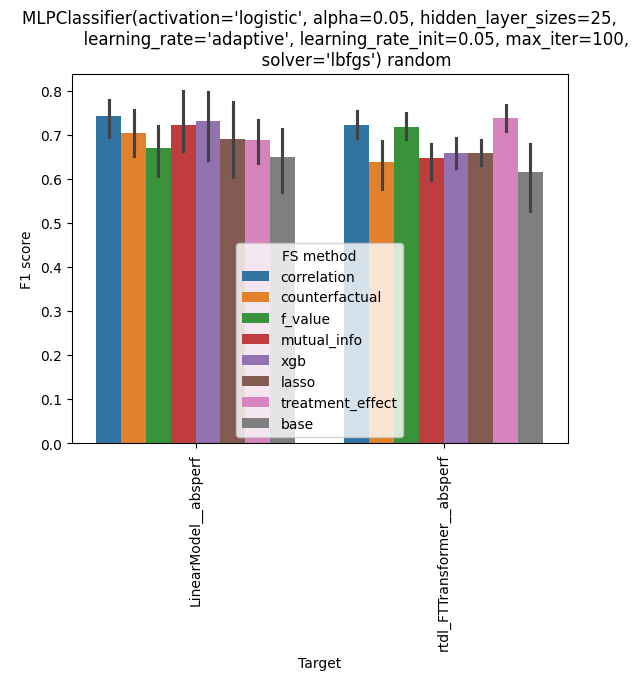

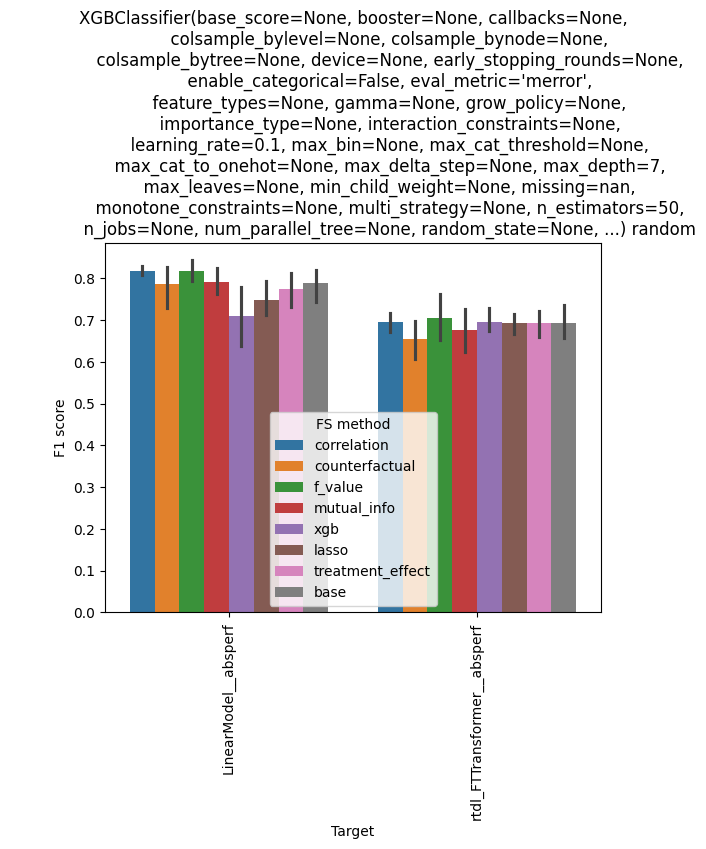

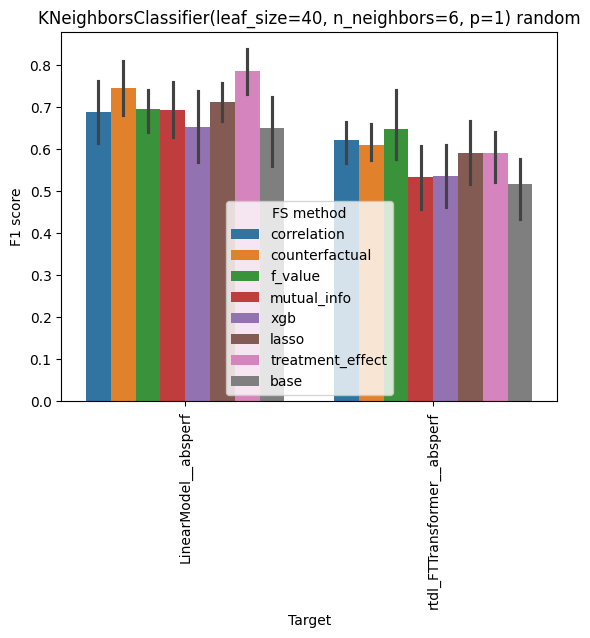

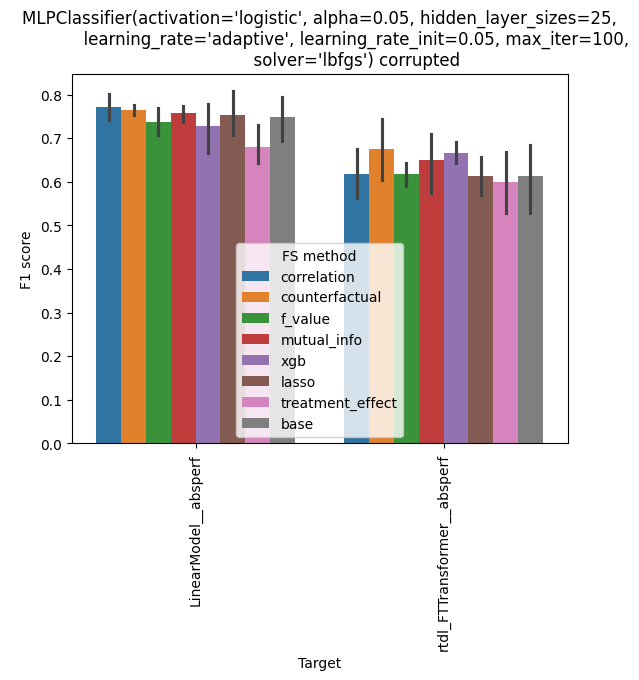

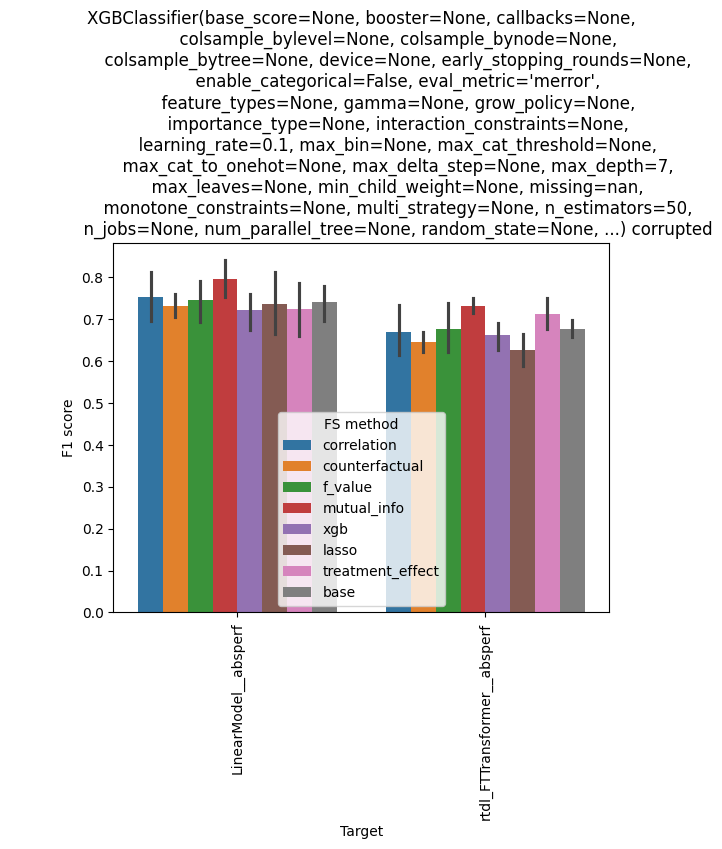

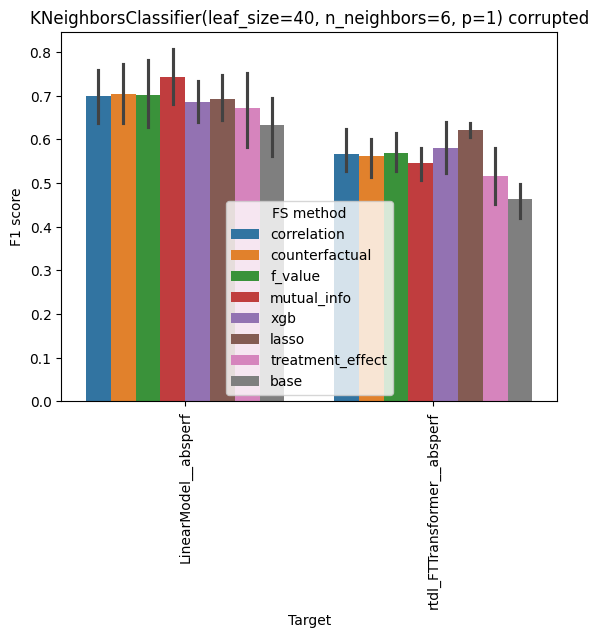

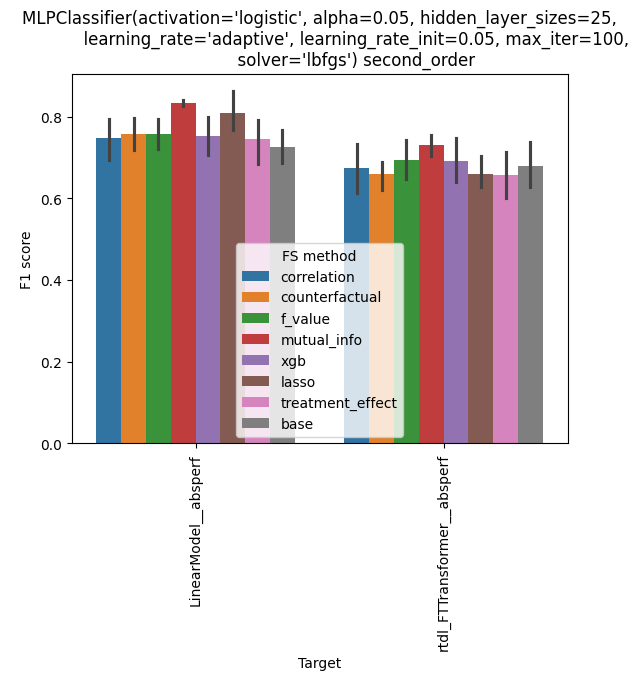

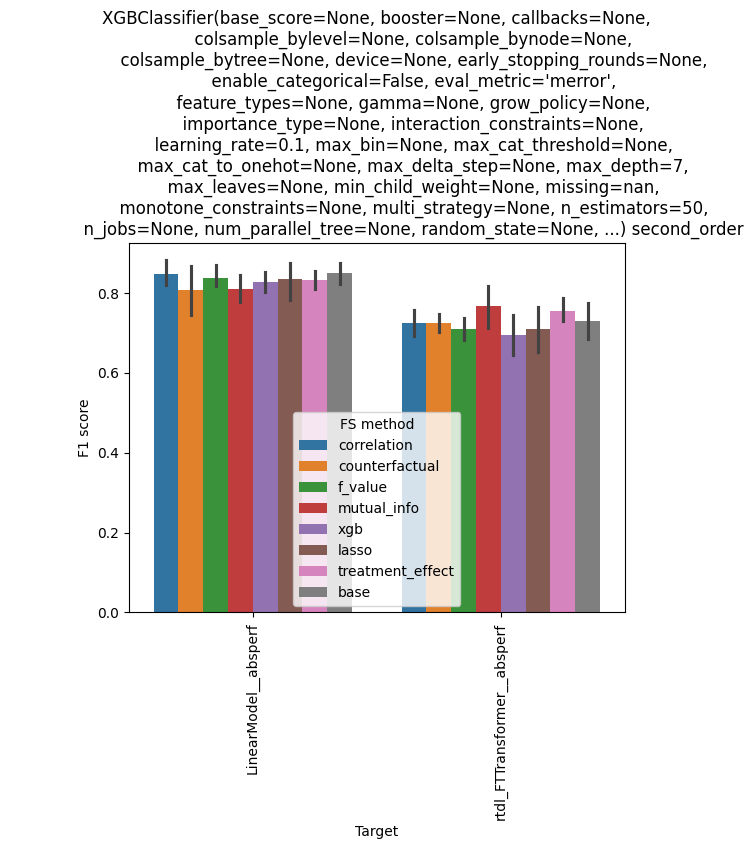

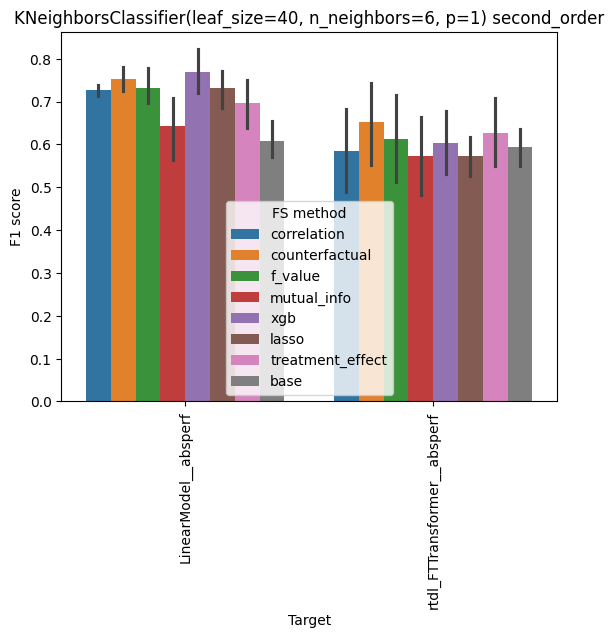

In [22]:
import seaborn as sns
for scenario in ['random', 'corrupted', 'second_order']:
    sample = result_df.loc[result_df['Shift type'] == scenario]
    for mtl in mtls:
        sample_final = sample.loc[sample['MtL'] == str(mtl)]
        plt.figure()
        plt.title(str(mtl) + ' '+scenario)
        plt.xticks(rotation = 90)
        sns.barplot(x='Target', y='F1 score', hue='FS method', data=sample_final)
    

In [23]:
def mlp_importance_getter(estimator):
    # Sum absolute weights from input layer to first hidden layer
    return np.sum(np.abs(estimator.coefs_[0]), axis=1)

In [24]:
meta_models = [

MetaModel(
        name="mlp",
        display_name="MLP",
        model=MLPClassifier(),
        params={
            "hidden_layer_sizes": 25,
            "activation": "logistic",
            "solver": "lbfgs",
            "alpha": 0.05,
            "batch_size": "auto",
            "learning_rate": "adaptive",
            "learning_rate_init": 0.05,
            "max_iter": 100,
        },
),

MetaModel(
        name="xgb",
        display_name="XGBoost",
        model=XGBClassifier(),
        params={
            'max_depth': 7,
            'learning_rate': 0.1,
            'n_estimators': 50,
            "eval_metric": "merror",
        }
),

MetaModel(
        name="knn",
        display_name="KNN",
        model=KNeighborsClassifier(),
        params={
            "n_neighbors": 6,
            "weights": "uniform",
            "leaf_size": 40,
            "algorithm": "auto",
            "p": 1,
        }
)]

In [25]:
for m in models:
    print(m)
    y = targets[m].values
    for scenario in ['random', 'corrupted', 'second_order']:
        print(f"Processing scenario: {scenario}")
        for n_added_features in [100]:
            # Add uninformative features
            if scenario == 'random':
                X_added = np.random.normal(size=(X.shape[0], n_added_features))
            elif scenario == 'corrupted':
                feature_indices = np.random.choice(X.shape[1], size=n_added_features, replace=True)
                X_added = X[:, feature_indices] + np.random.normal(scale=0.5,size=(X.shape[0], n_added_features))
            else:  # second_order
                X_added = np.zeros((X.shape[0], n_added_features))
                for i in range(n_added_features):
                    f1, f2 = np.random.choice(X.shape[1], 2, replace=False)
                    X_added[:, i] = X[:, f1] * X[:, f2]
            X_new = np.hstack([X, X_added])
            init_features = init_features_x + ['U '+ str(j) for j in range(n_added_features)]
            for _ in range(5):
                X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=0.3)
                for j, mtl in enumerate(mtls):
                    if meta_models[j].name != 'knn':
                        selector = RFESelector(md_source=None, model=mtl)
                        if meta_models[j].name == 'mlp':
                            selector = RFESelector(md_source=None, model=mtl, importance_getter=mlp_importance_getter)
                        df_res = selector.handle_data(X_train, y_train, init_features)
                        df_res.dropna(inplace=True)
                        selected_f = list(df_res.index)
                        selected_f_index = [i for i, f in enumerate(init_features) if f in selected_f]
                        X_train_selected = X_train[:,selected_f_index]
                        X_test_selected = X_test[:, selected_f_index]
                        model_selected = mtl
                        model_selected.fit(X_train_selected, y_train)
                        f1_score_selected = f1_score(y_test, model_selected.predict(X_test_selected))
                        df_dict = {'Target':[m], 'MtL':[str(mtl)], 'FS method':[selector.class_name], 'Shift type':[scenario], '%':[(n_added_features*100) / (X.shape[1] + n_added_features)], 'F1 score':[f1_score_selected]}
                        result_df = pd.concat([result_df, pd.DataFrame.from_dict(df_dict)])
                        print(result_df)

LinearModel__absperf
Processing scenario: random
                         Target  \
0          LinearModel__absperf   
0          LinearModel__absperf   
0          LinearModel__absperf   
0          LinearModel__absperf   
0          LinearModel__absperf   
..                          ...   
0   rtdl_FTTransformer__absperf   
0   rtdl_FTTransformer__absperf   
0   rtdl_FTTransformer__absperf   
0   rtdl_FTTransformer__absperf   
0          LinearModel__absperf   

                                                  MtL         FS method  \
0   MLPClassifier(activation='logistic', alpha=0.0...       correlation   
0   XGBClassifier(base_score=None, booster=None, c...       correlation   
0   KNeighborsClassifier(leaf_size=40, n_neighbors...       correlation   
0   MLPClassifier(activation='logistic', alpha=0.0...    counterfactual   
0   XGBClassifier(base_score=None, booster=None, c...    counterfactual   
..                                                ...               ...   
0   K

In [26]:
result_df.to_csv('uninformative_perf_abs_target2.csv', index=False)